## BF Effect on Galaxy Shape w/ Galsim (Real Galaxy Catalog)

Originally created by Alex Broughton


In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          g0b29ad24fb+d238567eb0 	current w_latest w_2022_45 setup


In [2]:
# Helper functions
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import logging
## create logger
#logger = logging.getLogger('simple_example')
#logger.setLevel(logging.DEBUG)

def calc2ndMom(results):
    # Calculate Second Moments
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy

### Read in COSMOS data

In [5]:
! galsim_download_cosmos -s 25.2 # Only need to do once! (Takes several minutes)

Type galsim_download_cosmos -h to see command line options.

  https://zenodo.org/record/3242143/files/COSMOS_25.2_training_sample.tar.gz
Target location is:
  /sdf/home/a/abrought/.local/lib/python3.8/site-packages/galsim/share/COSMOS_25.2_training_sample.tar.gz

Size of COSMOS_25.2_training_sample.tar.gz: 4167 MBytes

Downloading:     0 / 4167 MBytes  [0.00%Downloading:     0 / 4167 MBytes  [0.00%Downloading:     0 / 4167 MBytes  [0.00%Downloading:     0 / 4167 MBytes  [0.00%Downloading:     0 / 4167 MBytes  [0.00%Downloading:     0 / 4167 MBytes  [0.00%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.01%Downloading:     0 / 4167 MBytes  [0.0

Checking the example files...

In [5]:
h = fits.open("/sdf/home/a/abrought/run5/BF/data/RealGalaxyCatalogs/real_galaxy_catalog_23.5_example.fits")
h.info()
print()
h = fits.open("/sdf/home/a/abrought/run5/BF/data/RealGalaxyCatalogs/real_galaxy_images.fits")
h.info()

Filename: /sdf/home/a/abrought/run5/BF/data/RealGalaxyCatalogs/real_galaxy_catalog_23.5_example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     38   100R x 15C   [J, D, D, D, 5A, D, 32A, 36A, J, J, D, D, D, 26A, D]   

Filename: /sdf/home/a/abrought/run5/BF/data/RealGalaxyCatalogs/real_galaxy_images.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (99, 53)   float32   
  1                1 ImageHDU         7   (47, 69)   float32   
  2                1 ImageHDU         7   (67, 197)   float32   
  3                1 ImageHDU         7   (81, 89)   float32   
  4                1 ImageHDU         7   (49, 69)   float32   
  5                1 ImageHDU         7   (71, 29)   float32   
  6                1 ImageHDU         7   (49, 87)   float32   
  7                1 ImageHDU         7   (61, 33)   float32   
  8         

### Using HST COSMOS catalog to discover BF impact on Shape

Based on example from Galsim documentation. Here I am using the paramaterized galaxies because the "real" galaxies are Deconvolution objects and cannot be drawn using BF method.

In [6]:
im_size = 64
pix_scale = 0.2 # LSST, HST = 0.05
exp_time = 15 #s
tel_diam = 8.4 #m for LSST
hst_eff_area = 2.4**2 * (1.-0.33**2) # From Galsim documentation
flux_scaling = (tel_diam**2/hst_eff_area) * exp_time

bp_file = os.path.join(galsim.meta_data.share_dir, 'wfc_F814W.dat.gz')
bandpass = galsim.Bandpass(bp_file, wave_type='ang').thin().withZeropoint(25.94)
cosmos_cat = galsim.COSMOSCatalog()
psf = galsim.OpticalPSF(diam=2.4, lam=1000.) # bigger than HST F814W PSF.
indices = np.arange(2000)
real_gal_list = cosmos_cat.makeGalaxy(indices, gal_type='real',
                                      noise_pad_size=im_size*pix_scale)
param_gal_list = cosmos_cat.makeGalaxy(indices, gal_type='parametric', chromatic=True)

print(cosmos_cat.__len__())

OSError: No RealGalaxy catalog found in /sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/galsim/share/COSMOS_25.2_training_sample. Run the program galsim_download_cosmos -s 25.2 to download catalog and accompanying image files.

1999 Completed succesfully!


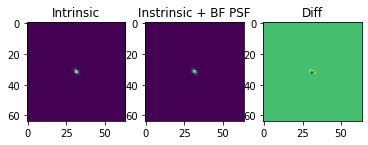

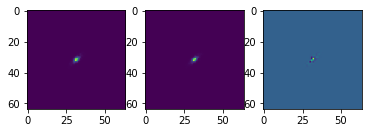

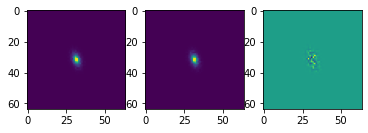

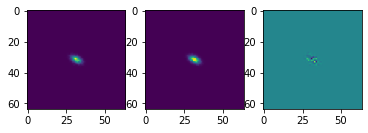

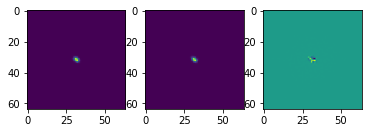

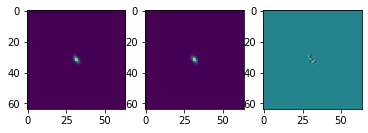

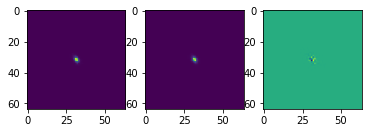

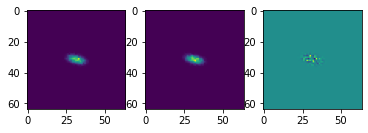

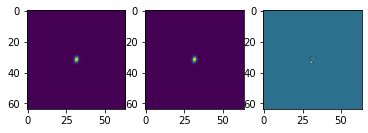

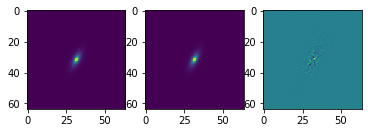

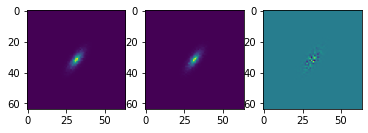

In [11]:
hsm_results = []
hsm_bf_results = []
num_failed = 0
for i, ind in enumerate(indices):
    # Generate separate galaxy objects
    param_gal = galsim.Convolve(param_gal_list[ind], psf)
    im_param = galsim.Image(im_size, im_size)
    param_gal_bf = galsim.Convolve(param_gal_list[ind], psf)
    im_param_bf = galsim.Image(im_size, im_size)
    
    param_gal *= flux_scaling
    param_gal_bf *= flux_scaling

    # Apply lateral diffusion
    sensor = galsim.SiliconSensor(strength = 0.0001, diffusion_factor=1., nrecalc=1000)
    img = param_gal.drawImage(bandpass, image=im_param, scale=pix_scale, sensor=sensor)
    
    # Apply lateral diffusion + BF
    sensor = galsim.SiliconSensor(strength = 1.0, diffusion_factor=1., nrecalc=1000)
    img_bf = param_gal_bf.drawImage(bandpass, image=im_param_bf, scale=pix_scale, sensor=sensor)
    
    # Plot the first 10
    if i <= 10:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(img.array)
        ax2.imshow(img_bf.array)
        ax3.imshow(img_bf.array - img.array)

        if i==0:
            ax1.set_title("Intrinsic")
            ax2.set_title("Instrinsic + BF PSF")
            ax3.set_title("Diff")
    try:  
        hsm_results.append(img.FindAdaptiveMom())
        hsm_bf_results.append(img_bf.FindAdaptiveMom())
    except:
        num_failed += 1
        continue

    #img.write('im_intrinsic_'+str(ind)+'.fits')
    #img_bf.write('im_intrinsic+BF_'+str(ind)+'.fits')

print(len(indices) - num_failed, "Completed succesfully!")

Text(0, 0.5, 'counts/bin')

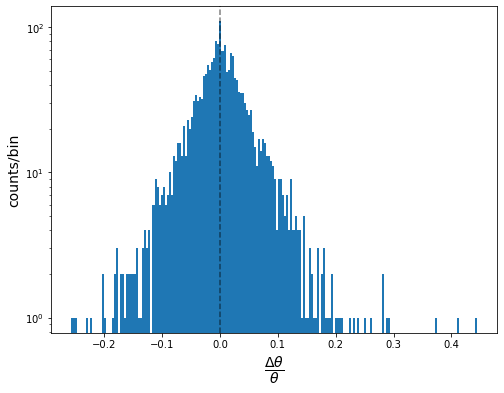

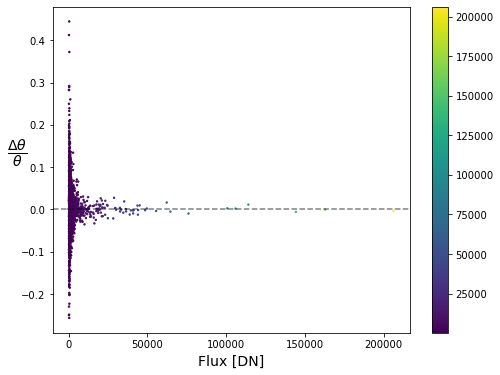

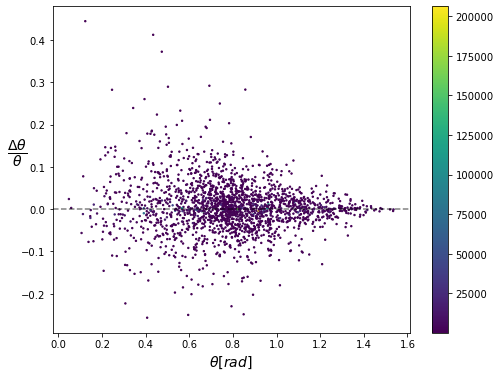

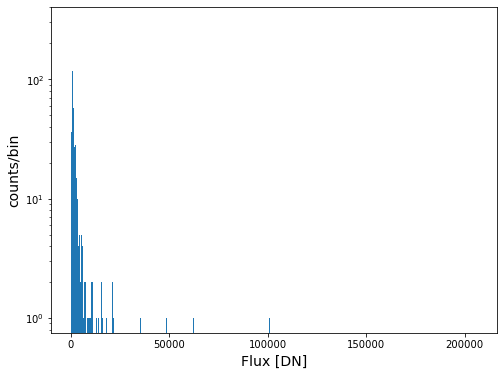

In [12]:
thetas = []
thetas_bf = []
flux = []
for result, result_bf in zip(hsm_results, hsm_bf_results):
    Ixx, Iyy, Ixy = calc2ndMom(result)
    Ixx_bf, Iyy_bf, Ixy_bf = calc2ndMom(result_bf)
    
    flux.append(result.moments_amp)
    
    theta = np.arctan(Iyy / Ixx)
    theta_bf = np.arctan(Iyy_bf / Ixx_bf)
    
    thetas.append(theta)
    thetas_bf.append(theta_bf)

thetas = np.asarray(thetas)
thetas_bf = np.asarray(thetas_bf)

plt.figure(figsize=(8,6))
plt.axvline(0.0, linestyle="--", color="k", alpha=0.5)
plt.hist((thetas_bf-thetas) / thetas, bins=200, log=True)
plt.xlabel(r"$\frac{\Delta\theta}{\theta}$", fontsize=20)
plt.ylabel("counts/bin", fontsize=14)


plt.figure(figsize=(8,6))
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5)
sca = plt.scatter(flux, (thetas_bf-thetas) / thetas, c=flux, s = 2)
plt.colorbar(sca)
plt.ylabel(r"$\frac{\Delta\theta}{\theta}$", rotation=360, fontsize=20)
plt.xlabel("Flux [DN]", fontsize=14)

plt.figure(figsize=(8,6))
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5)
sca = plt.scatter(thetas, (thetas_bf-thetas) / thetas, c=flux, s = 2)
plt.colorbar(sca)
plt.ylabel(r"$\frac{\Delta\theta}{\theta}$", rotation=360, fontsize=20)
plt.xlabel(r"$\theta [rad]$", fontsize=14)

plt.figure(figsize=(8,6))
plt.hist(flux, bins=2000, log=True)

plt.xlabel("Flux [DN]", fontsize=14)
plt.ylabel("counts/bin", fontsize=14)

### Playing around with the example files

In [8]:
cat_file_name = 'real_galaxy_catalog_23.5_example.fits'
dir ='/sdf/home/a/abrought/run5/BF/data/RealGalaxyCatalogs'
real_galaxy_catalog = galsim.RealGalaxyCatalog(cat_file_name, dir=dir)


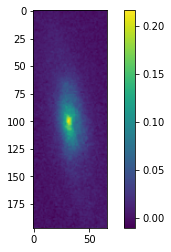

In [9]:
i = 2
plt.imshow(real_galaxy_catalog.getGalImage(i).array)
plt.colorbar()

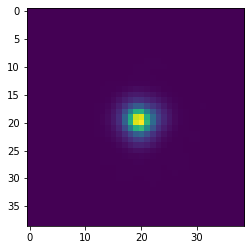

In [10]:
plt.imshow(real_galaxy_catalog.getPSF(i)._image.array)

In [ ]:
# Get image dimensions
dimensions = real_galaxy_catalog.getGalImage(i).array.shape

# add BF effect
sensor = galsim.SiliconSensor(strength = 1., diffusion_factor=1., nrecalc=10000)

gal = galsim.RealGalaxy(real_galaxy_catalog, index = i, flux=1.0e5)
image1 = gal.drawImage(scale=0.03, sensor=sensor)

#blank_image = galsim.Image(dimensions[1],dimensions[0],scale=0.03,dtype=np.float64)  
#image1 = gal.drawImage(image=blank_image, scale=0.03, method="auto")
print(image1.array.shape)
plt.figure(figsize=(10,8))
plt.imshow(image1.array)

In [ ]:
h = plt.hist(image1.array.flatten(), bins=100)

### Old Galaxy distortion simulation

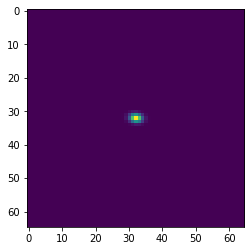

In [4]:
import sys
import os
import math
import logging
import galsim

"""
About as simple as it gets:
  - Use a circular Gaussian profile for the galaxy.
  - Convolve it by a circular Gaussian PSF.
  - Add Gaussian noise to the image.
"""

gal_flux = 2.0e4    # total counts on the image
gal_sigma = 0.2     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 10.        # standard deviation of the counts in each pixel

# add BF effect
sensor = galsim.SiliconSensor(strength = 1., diffusion_factor=1., nrecalc=10000)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma) * sed
final = gal.shear(g1=0.2, g2=0.05).evaluateAtWavelength(680.0)


# Draw the image with a particular pixel scale, given in arcsec/pixel.
# The returned image has a member, added_flux, which is gives the total flux actually added to
# the image.  One could use this value to check if the image is large enough for some desired
# accuracy level.  Here, we just ignore it.

blank_image = galsim.Image(65,65,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
image1 = final.drawImage(image=blank_image, scale=0.2, method="phot", save_photons=True)


# Add Gaussian noise to the image with specified sigma
# image.addNoise(galsim.GaussianNoise(sigma=noise))

# calculate HSM moments (these are in pixel coordinates)
results = image1.FindAdaptiveMom()
Ixx, Iyy, Ixy = calc2ndMom(results)
flux = results.moments_amp

plt.imshow(image1.array)

In [5]:
print(Ixx, Iyy, Ixy)

1.5907109313304766 0.728695088663072 0.10037337247607274


### Without BF

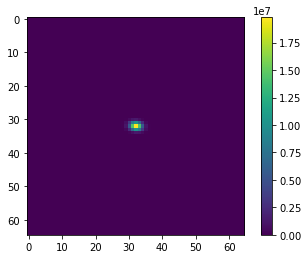

In [11]:
import sys
import os
import math
import logging
import galsim

"""
About as simple as it gets:
  - Use a circular Gaussian profile for the galaxy.
  - Convolve it by a circular Gaussian PSF.
  - Add Gaussian noise to the image.
"""

gal_flux = 2.e5    # total counts on the image
gal_sigma = 0.2     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 10.        # standard deviation of the counts in each pixel

# add BF effect
sensor = galsim.SiliconSensor(strength = 0.0001, diffusion_factor=1., nrecalc=10000)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma) * sed
final = gal.shear(g1=0.2, g2=0.05).evaluateAtWavelength(680.0)


# Draw the image with a particular pixel scale, given in arcsec/pixel.
# The returned image has a member, added_flux, which is gives the total flux actually added to
# the image.  One could use this value to check if the image is large enough for some desired
# accuracy level.  Here, we just ignore it.

blank_image = galsim.Image(65,65,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
image2 = final.drawImage(image=blank_image, scale=0.2, method="phot", save_photons=True)


# Add Gaussian noise to the image with specified sigma
# image.addNoise(galsim.GaussianNoise(sigma=noise))

# calculate HSM moments (these are in pixel coordinates)
results = image2.FindAdaptiveMom()
Ixx, Iyy, Ixy = calc2ndMom(results)
flux = results.moments_amp

plt.imshow(image2.array)
plt.colorbar()

In [7]:
print(Ixx, Iyy, Ixy)

1.5912072863297602 0.7288545654252787 0.1006859930808992


/tmp/ipykernel_75059/727903430.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((image1.array-image2.array)/image2.array)


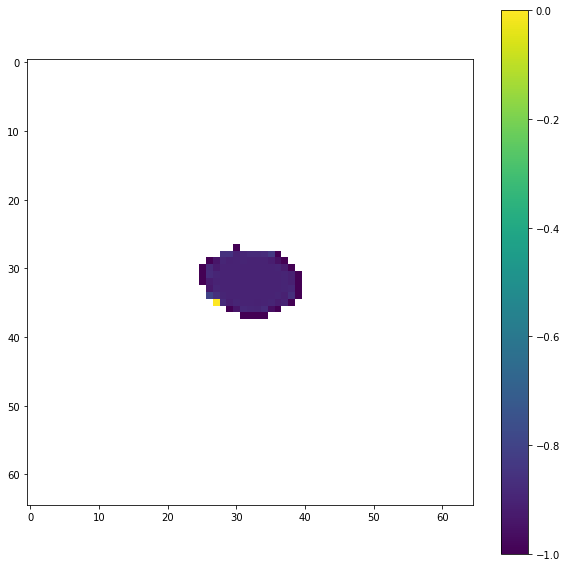

In [12]:
plt.figure(figsize=(10,10))
plt.imshow((image1.array-image2.array)/image2.array)
plt.colorbar()